In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23777%2F30378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240803%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240803T115713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51e68d3f85136f91a791f5a4d477ed726f1693cafa6f3443ada8a51bc716a925b979e2ed81f315293e6e04a2fbec92095821d7d3931848d0f7962ca9224f79adcbe568fb26657d6366d9bf088be002c71a06c537c38e8267be2f575c52ae885ad7fa93a037efb26f5cfff09e648dae95e8ff9003b2e992537629e8484b29996b002924d7da9d1852a8cdb0b4f4382b1dbd0f0c4c9d0b19d40fa29e2ebf30e3f6adb400a140c423e41577dcfb3bd8d249523a09dd34a35bb3bc41f985fdc62b138f8527d7be4bd7c52990245a33cc3060fae35db5f2c64bd8a8f0d001922094a1d932a78858f2221c90daf0fe1ff365fb76ffbb3976c974c4adcb0b90843055c6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 228487605 bytes downloaded
Downloaded and uncompressed: cat-and-dog
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

training_set = datagen.flow_from_directory(
        "../input/cat-and-dog/training_set/training_set/",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )


Found 8005 images belonging to 2 classes.


In [5]:
datagen1 = ImageDataGenerator(rescale=1./255)

test_set = datagen1.flow_from_directory(
        "../input/cat-and-dog/test_set/test_set",
        target_size=(64, 64),
        batch_size=32,
        class_mode="binary"
      )

Found 2023 images belonging to 2 classes.


In [6]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense

In [7]:
from tensorflow.keras.regularizers import l2

In [8]:
cnn = tf.keras.models.Sequential()

In [9]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

In [10]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [11]:
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [12]:
cnn.add(tf.keras.layers.Flatten())

In [13]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

In [14]:
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [15]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,545 (1.04 MB)

 Trainable params: 272,545 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

In [17]:
r=cnn.fit(x = training_set, validation_data = test_set, epochs = 15)

Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step - accuracy: 0.5181 - loss: 0.9964 - val_accuracy: 0.6154 - val_loss: 0.7961
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.6376 - loss: 0.7843 - val_accuracy: 0.7128 - val_loss: 0.6965
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.6819 - loss: 0.6773 - val_accuracy: 0.7365 - val_loss: 0.6284
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.7114 - loss: 0.6406 - val_accuracy: 0.7509 - val_loss: 0.6284
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.7148 - loss: 0.6085 - val_accuracy: 0.7598 - val_loss: 0.5469
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.7328 - loss: 0.5740 - val_accuracy: 0.7568 - val_loss: 0.5292
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.7422 - loss: 0.5612 - val_accuracy: 0.7696 - val_loss: 0.5298
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 0.7563 - loss: 0.5293 -

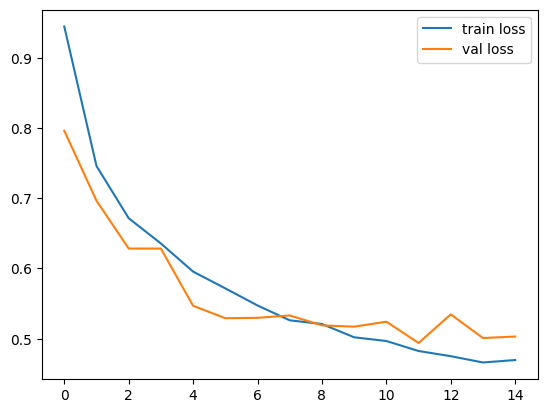

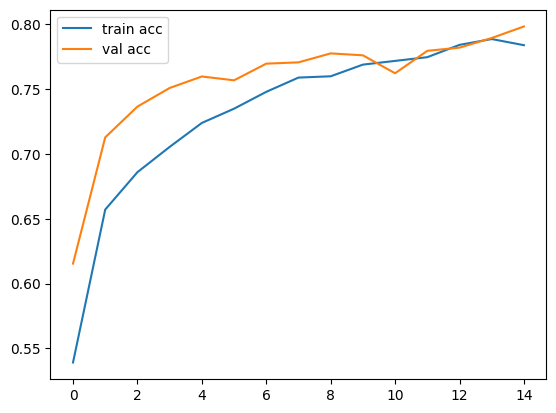

In [18]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [19]:
from tensorflow.keras.models import load_model

cnn.save('./model_rcat_dog.h5')

In [20]:
from tensorflow.keras.preprocessing import image
test_image = image.load_img('../input/cat-and-dog/training_set/training_set/dogs/dog.1023.jpg', target_size = (64,64))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


In [21]:
if result[0]<0:
    print("The image classified is cat")
else:
    print("The image classified is dog")

The image classified is dog
